d:\Users\amirh\anaconda3\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


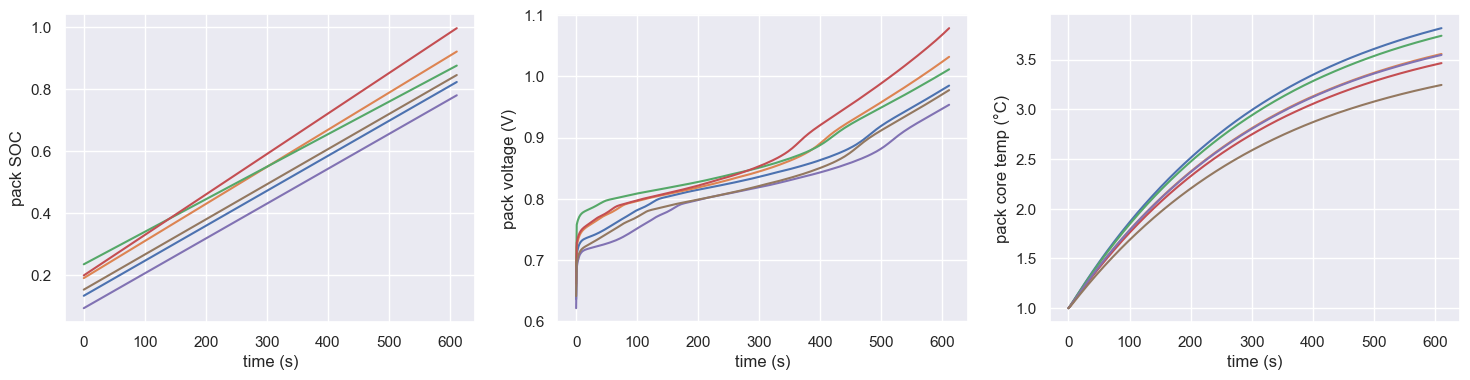

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym_delta import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)

pack_res=[]
rewards = []
pack_res.append(env.reset()[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:])
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:])
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# CC/CV without balancing

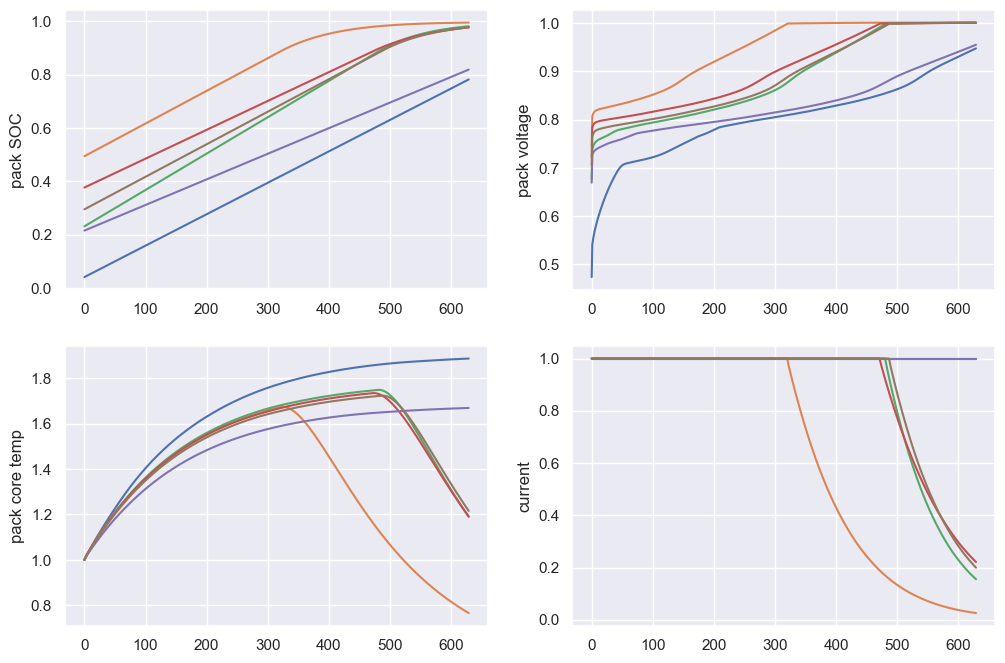

In [5]:
from copy import copy

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)


CC = 100
Rbal = 10000
env.overcharge_voltage = 4.1

state, _ = env.reset()

pack_res = []
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    copy_env = copy(env)
    v = copy_env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
    ik = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV
    ik = np.clip(-CC,ik,0); # but limit ik to no more than CC in mag.
    action = np.hstack([ik.ravel()/env.current_ratio,1])
    next_state, reward, done, _, info = env.step(action)
    state = next_state

    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')


# CC/CV with balancing

d:\Users\amirh\anaconda3\lib\site-packages\gymnasium\spaces\box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


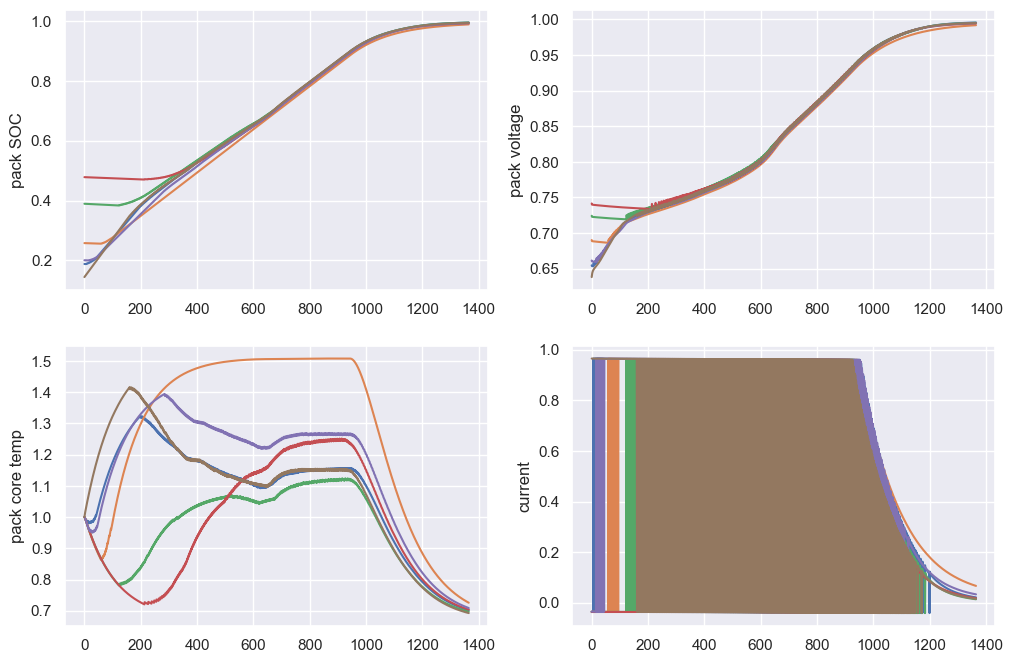

In [128]:
from copy import copy

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)


CC = 100
Rbal = 1
env.overcharge_voltage = 4.1

state, _ = env.reset()

pack_res = []
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    # check balance 
    cell_voltages = state[6:12]*(env.max_voltage-env.min_voltage) + env.min_voltage
    checkBalance = ((cell_voltages - cell_voltages.min()) <= 1e-2)
    
    # CC/CV
    copy_env = copy(env)
    v = copy_env.step(np.zeros(7))[0][6:12] * (env.max_voltage-env.min_voltage) + env.min_voltage # fixed voltage
    i_charge = (v - env.overcharge_voltage)/env.pack.ECM.R0Param; # compute test ik to achieve maxV
    i_charge = np.clip(-CC,i_charge,0)*checkBalance # but limit ik to no more than CC in mag.
    action_charge = np.hstack([i_charge.ravel()/env.current_ratio,1])
    next_state, reward, done, _, info = env.step(action_charge)
    state = next_state
    
    # passive balancing
    v_balance = cell_voltages#*checkBalance 
    i_balance = (v_balance/Rbal)   # Current calculated for balance cell, with parallel resistor 
    i_balance = np.clip(0,i_balance,CC)
    
    action_balance = np.hstack([i_balance.ravel()/env.current_ratio,1])

    next_state, reward, done, _, info = env.step(action_balance)
    state = next_state
    
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action_charge+action_balance)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:,:-1].reshape(-1,6))
plt.ylabel('current')
plt.grid('on')